
### План проекта по парсингу данных с Python  
**I. Цели и задачи парсинга**

* Земельные участки

Площадь до 10000 м² внутри КАДа, за КАДом - более 10000 м2
* Здания


* Нежилые помещения

Площадь до 200 м² внутри КАДа
Площадь более 200 м² за КАДом

**II. Источники данных**

* <a target="_blank" href="https://torgi.gov.ru/new/public/lots/reg">ГИС ТОРГИ</a>

* <a target="_blank" href="https://spb.cian.ru/">ЦИАН</a>


**III. Требуемые данные**

* Расположение объекта

* Цена объекта

* Площадь объекта

* ВРИ участка (для земельных участков)
* Удаленность от ближайшего метро, автобусной остановки, города (если объект находится за его пределами)
* Сезон продажи объекта
* Категория помещения (для зданий и нежилых помещений)

**IV. Анализ данных**
* Цена объекта и его местоположение
* Зависимость цены объекта от площади, средняя стоимость квадратного метра объекта
* Средняя цена объекта в зависимости от ВРИ объекта
* Влияние времени года на цену объекта




___
##Этапы разработики проекта
1. Сбор данных (Парсинг)


2. Обработка данных

Инструменты:

* pandas

Задачи:
Очистка данных, фильтрация данных по критериям (например, по площади и расположению), вычисление необходимых метрик (например, средняя цена, средняя стоимость квадратного метра)

* регулярные выражения

* yandex_geocoder

Задачи: вычисление координат по адресу объекта

3. Анализ данных

Инструменты:

* pandas, numpy, matplotlib, seaborn, линейные регрессии(np.polyfit) и другое

Задачи:
Анализ данных по заданным критериям, визуализация результатов анализа

В своем проекте я использовала основную часть материала, пройденного на курсе

___
##Гипотезы и поставленные вопросы

1) Гипотеза о том, что разница между начальной ценой и конечной у объектов недвижимости **выше** в летний период

2) Гипотеза о том, что цена на объекты внутри КАДа с ростом общей площади растет **быстрее**, чем на объекты за КАДом

3) Какой **ВРИ**(вид разрешенного использования) самый ценный среди объектов внутри КАДа и за ним?


___
## 0. Импорт библиотек

Необходимые пакеты

In [ ]:
!pip install yandex-geocoder
!pip install openpyxl

In [ ]:
import numpy as np
import pandas as pd

import re

# Графики
import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from time import sleep # Перерыв между запросами

# Геокодеры (получить координаты по адресу)
from geopy.geocoders import Nominatim

import yandex_geocoder

from google.colab import files

import os # Для работы с именами файлов

import seaborn as sns # Более удобные графики

import warnings
warnings.filterwarnings('ignore')

import datetime

In [ ]:
# Константы
MAPBOX_TOKEN = "pk.eyJ1IjoibmJhcnlraW4iLCJhIjoiY2xzc3R2c2ZvMHlweDJscWkxcWc3bG1taiJ9.mO3_ujVU5ZxAOJJrwp_v4w"
YANDEX_GEOCODER_KEYS = ["557b874e-fa6f-45d0-8245-2dd36f183d59", "2e9a0ea7-3ab2-4e80-aca3-c524b44bfaa3"]

In [ ]:
px.set_mapbox_access_token(MAPBOX_TOKEN)
pio.renderers.default = 'colab'

# Формирование единой таблицы

Сначала я загрузила таблицы с сайтов ГИС торги и ЦИАН. Делала я это напрямую, выбирая нужные параметры и выгружая с сайта таблицы Excel. Для каждого сайта и скачала по 5 таблиц, разделенных категориями: здания, нежилое внутри КАДа и за КАДом, земля внутри КАДа и за КАДом. В сумме получила 10 отдельных таблиц.

Далее создала единую таблицу для всех видов объектов со всех сайтов, чтобы удобнее было проделывать дальнейшие манипуляции.

## Парсинг нужной информации

### Начальная цена

In [ ]:
def get_initial_price(table_name: str, table: pd.DataFrame) -> pd.Series:
  """
  функция достает нужную цену из отдельных таблиц. Для таблиц с ГИС торги использую начальную цену(она есть почти всегда),
  у таблиц с ЦИАНа есть только один столбец с ценой, его и беру
  """
  if "ГИС" in table_name:
    return table["Начальная цена"]
  else:
    # У ЦИАН цена имеет вид "8500000 руб., УСН"
    return table["Цена"].apply(lambda x: float(x.split()[0]))

### Итоговая цена

In [ ]:
def get_final_price(table_name: str, table: pd.DataFrame) -> pd.Series:
  """
  нахожу итоговую цену(в этом плане таблицы с ГИС торги более информативны, так как там есть вся информация об аукционах)
  """
  if "ГИС" in table_name:
    return table["Итоговая цена"]
  else: # В случае ЦИАН начальная цена совпадает с итоговой
    return get_initial_price(table_name, table)

### Площадь

In [ ]:
def get_area(table_name: str, table: pd.DataFrame) -> pd.Series:
  """
  Из записей о продажах вычленить площадь объекта в квадратных метрах.

  Вернуть pd.Series с вещественными числами длины len(table)
  """

  if "ГИС" in table_name:
    target_column = "Характеристики имущества"

    def extract_area(source: str):
      # Например, "Общая площадь : 101.10 м^2 общ. пл; Количество этажей  : 2"
      template = r"(Площадь земельного участка.*|Общая площадь)\s*:\s*([0-9.]*)\s*м\^2.*"
      search_result = re.search(template, source)

      if search_result is None:
        print("Bad source: ", source)

      return float(search_result.group(2))

  else: # ЦИАН
    target_column = "Площадь"

    def extract_area(source: str):
        # Например, "727.1, м2"

        template = r"([0-9.]*), (м2|сот|га).*"
        search_result = re.search(template, source)

        value = float(search_result.group(1))
        units_of_measurement = search_result.group(2)

        match units_of_measurement:
          case "м2":
            return value
          case "сот":
            return value * 100 # в сотке сто квадратов
          case "га":
            return value * 10000 # а в гектаре десять тысяч
          case _:
            raise Exception("Неизвестная единица измерения")

  return table[target_column].apply(extract_area)

### Координаты

In [ ]:
def find_coordinates_by_address(address: str) -> tuple[float, float]:
  """
  Возвращает пару (широта, долгота)
  """
  for yandex_geocoder_key in YANDEX_GEOCODER_KEYS:
    try:
      client = yandex_geocoder.Client(yandex_geocoder_key)
      longitude, latitude = client.coordinates(address)
      return float(latitude), float(longitude)

    except Exception: # Превышено количество запросов для данного ключа
      pass

  # Все геокодеры отказали
  raise Exception("превышен лимит запросов (вероятно)")

In [ ]:
def get_coordinates(table_name: str, table: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
  """
  Возвращает пару (массив широт, массив долгот)
  """
  if "Широта" in table.columns and "Долгота" in table.columns:
    return table["Широта"], table["Долгота"]

  address_column = ("Адрес" if "ЦИАН" in table_name   # ЦИАН
                    else "Местонахождение имущества") # ГИС

  coordinates = table[address_column].apply(find_coordinates_by_address)

  def build_projection(index):
    def projection(x):
      try:
        return x[index]
      except Exception:
        return None

    return projection

  lattitudes = coordinates.apply(build_projection(0))
  longitudes = coordinates.apply(build_projection(1))

  return lattitudes, longitudes

### Тип объекта(здание/земельный участок/нежилое помещение)

In [ ]:
def get_object_type(table_name: str, table: pd.DataFrame) -> pd.Series:
  if "здания" in table_name:
    type_value = "здание"
  elif "земля" in table_name:
    type_value = "земельный участок"
  else:
    type_value = "нежилое помещение"

  return pd.Series(type_value, index=table.index)

### Дата сделки

In [ ]:
def parse_date(date_str):
  """
  Например, "05.07.2024 10:00 (МСК)" или nan (в случае пропуска)
  """
  if isinstance(date_str, str):
    return datetime.datetime.strptime(date_str.split()[0], "%d.%m.%Y")
  else:
    return None

In [ ]:
def get_date(table_name: str, table: pd.DataFrame) -> pd.Series:
  if "ГИС" in table_name:
    return table["Дата и время начала аукциона"].apply(parse_date)
  else:
    return pd.Series(None, index=table.index)

### ВРИ (вид разрешенного использования)

In [ ]:
def parse_type_of_permited_use(characteristics: str) -> str:
  """
  Например "Вид разрешённого использования земельного участка : Для индивидуального жилищного строительства"
  """
  search_template = r"Вид разрешённого использования земельного участка\s*:\s*(.*?)\s*(;|$)"
  search_result = re.search(search_template, characteristics)
  return search_result and search_result.group(1)

In [ ]:
def get_type_of_permited_use(table_name: str, table: pd.DataFrame) -> pd.Series:
  if "ГИС" in table_name:
    return table["Характеристики имущества"].apply(parse_type_of_permited_use)
  else:
    return pd.Series(None, index=table.index)

### Внутри КАДа или снаружи

In [ ]:
def get_inside_cad(table_name: str, table: pd.DataFrame) -> pd.Series:
  if "внутри_КАДа" in table_name:
    value = True
  elif "за_КАДом" in table_name:
    value = False
  else:
    value = None

  return pd.Series(value, index=table.index)

## Загрузка таблиц и объединение в одну таблицу

загружаем таблицы в колаб

In [ ]:
input_files = files.upload()

input_tables = {}
for filename in input_files.keys():
  # Делаем в конце сплит, чтобы обработать, например, такое имя файла "агрегированные_сделки (4).xlsx"
  table_name = os.path.splitext(filename)[0].split()[0]
  table = pd.read_excel(filename)
  input_tables[table_name] = table

Saving агрегированные_сделки.xlsx to агрегированные_сделки (5).xlsx


создаем единую таблицу

In [ ]:
if list(input_tables.keys()) == ["агрегированные_сделки"]:
  # Пользователь загрузил уже объединенную версию
  data = list(input_tables.values())[0]
else: # нужно собирать единую таблицу из остальных
  data = pd.DataFrame()

  for filename in input_tables.keys():
    table_name = os.path.splitext(filename)[0]
    table = pd.read_excel(filename)

    normalized_table = pd.DataFrame()

    normalized_table["Тип объекта"] = get_object_type(table_name, table)
    normalized_table["Внутри КАДа"] = get_inside_cad(table_name, table)
    normalized_table["Дата сделки"] = get_date(table_name, table)
    normalized_table["Начальная цена"] = get_initial_price(table_name, table)
    normalized_table["Итоговая цена"] = get_final_price(table_name, table)
    normalized_table["Площадь, м2"] = get_area(table_name, table)
    normalized_table["Начальная цена за квадратный метр"] = normalized_table["Начальная цена"] / normalized_table["Площадь, м2"]
    normalized_table["Широта"], normalized_table["Долгота"] = get_coordinates(table_name, table)
    normalized_table["ВРИ"] = get_type_of_permited_use(table_name, table)

    data = pd.concat([data, normalized_table], ignore_index=True)

  data = data[(data["Начальная цена"] <= 8e8) & (data["Площадь, м2"] <= 12000)]

data.head()

,Тип объекта,Внутри КАДа,Дата сделки,Начальная цена,Итоговая цена,"Площадь, м2",Начальная цена за квадратный метр,Широта,Долгота,ВРИ,Относительный рост цены
0,здание,NaN,2024-07-05,207590000.0,NaN,727.1,285504.057214,59.965786,30.280888,NaN,NaN
1,здание,NaN,2024-07-05,243600000.0,NaN,4796.7,50784.914629,59.707860,30.381292,NaN,NaN
2,здание,NaN,2024-07-02,9684000.0,NaN,453.5,21353.914002,59.653912,30.400462,NaN,NaN
3,здание,NaN,2024-07-02,14140000.0,NaN,275.0,51418.181818,59.908750,29.776313,NaN,NaN
4,здание,NaN,2024-06-20,9548000.0,NaN,101.1,94441.147379,60.167223,29.852400,NaN,NaN


Сохранение таблиц с координатами

In [ ]:
data.to_excel("агрегированные_сделки.xlsx", index=False, engine="openpyxl")
files.download("агрегированные_сделки.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Отображение цены на карте по каждой таблице

In [ ]:
for target_object_type in ["здание", "нежилое помещение", "земельный участок"]:
  target_entries = data[data["Тип объекта"] == target_object_type]

  target_entries = target_entries[~target_entries["Начальная цена за квадратный метр"].isna()]

  fig = px.density_mapbox(
      target_entries,
      lat="Широта",
      lon="Долгота",
      z="Начальная цена за квадратный метр",
      center=dict(lat=59.95, lon=30.4),
      zoom=9,
      radius=10,
      title=f"Тип объекта: {target_object_type}",
      color_continuous_scale = px.colors.sequential.Plasma,
      opacity=0.8,
      mapbox_style="open-street-map"
    )

  fig.update_layout(mapbox_style="open-street-map")

  fig.show(renderer="colab")

# Относительный рост цены от начала до конца торгов

Я хочу внимательнее посмотреть на таблицы с ГИС торги. В основном объекты продаются с помощью электронных аукционов. В таблице есть начальная цена и итоговая. Разницу между ними назовем дельта. Есть **гипотеза**, что эта дельта в весенне-летний период выше, чем в остальное время, что может быть связано с "игрой гормонов" у покупателей и инвесторов, чья любовь к риску увеличивается в это время года.  Давайте проверим это. Будем смотреть на относительные дельты


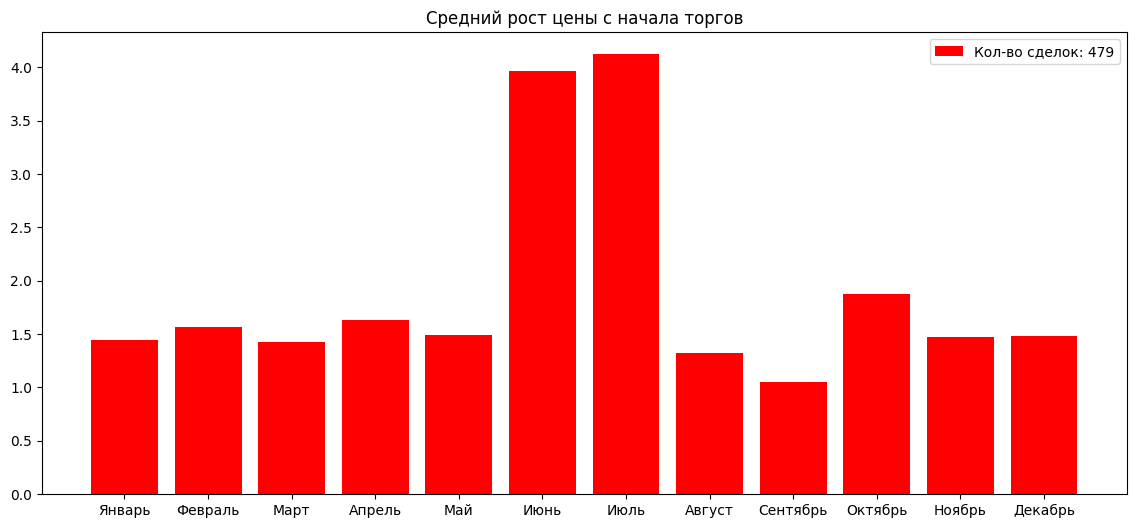

In [ ]:
MONTH_NAMES = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь", "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]

data["Относительный рост цены"] = data["Итоговая цена"] / data['Начальная цена']
target = data[~(data["Относительный рост цены"].isna() | data["Дата сделки"].isna())]
target["Месяц сделки"] = target["Дата сделки"].dt.month

groupped = target[["Месяц сделки", "Относительный рост цены"]].groupby("Месяц сделки").mean()
groupped.sort_index(inplace=True)

plt.figure(figsize=(14, 6))

month_number_to_name = lambda number: MONTH_NAMES[number - 1]

plt.bar(list(map(month_number_to_name, groupped.index)),
        groupped["Относительный рост цены"], color="red", label=f"Кол-во сделок: {len(target)}")

plt.legend()

plt.title("Средний рост цены с начала торгов")

plt.show();

Результаты подтверждают мою гипотезу. Внушительный рост дельт наблюдается в июне и июле. То есть, в это время года инвесторы более склонны соревноваться, предлагать более высокую стоимость недвижимости. Это также подтверждается статьями, в которых исследуется увеличение тяги к риску в определенное время [года](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=4b81bd6fd3c9acede621ca4db26af2e71b0b7ffa), связь риска с [погодой](https://www.sciencedirect.com/science/article/pii/S0929119920302054). Это достаточно ценный вывод, который мжет помочь ппродавцам недвижимости поднять цену на объект. Для этого можно просто начинать аукцион летом!

# Зависимость цены от площади

Теперь посмотрим на зависимость цены на объект от его площади. Я делаю предположение, что для объектов внутри КАДа она растет быстрее с ростом площади.

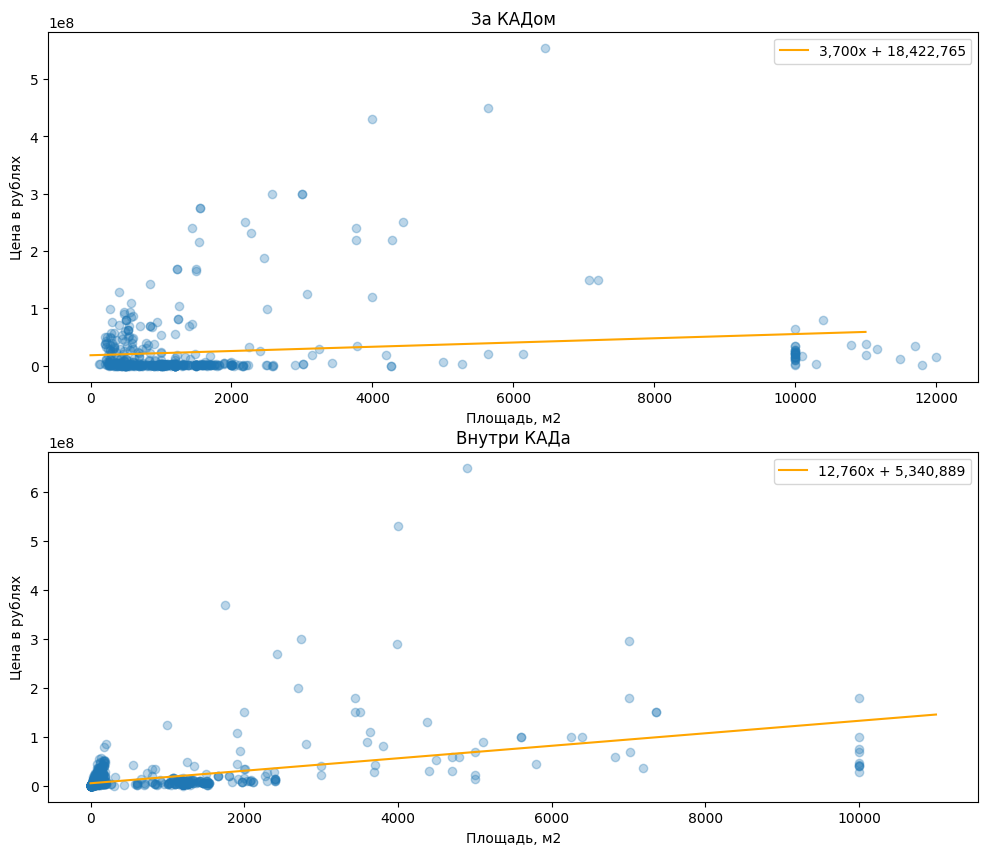

In [ ]:
fig, ax = plt.subplots(2, figsize=(12, 10))

for in_cad in [False, True]:
  target_entries = data[data["Внутри КАДа"] == in_cad]

  ax[int(in_cad)].scatter(target_entries["Площадь, м2"], target_entries["Начальная цена"], alpha=0.3)

  # Линейная аппроксимация цены от площади
  linear_approximation = np.polyfit(target_entries["Площадь, м2"], target_entries["Начальная цена"], deg=1)

  approx_xs = np.arange(0, 12000, 1000)
  approx_ys = approx_xs * linear_approximation[0] + linear_approximation[1]

  ax[int(in_cad)].plot(
      approx_xs,
      approx_ys,
      color="orange",
      label=f"{round(linear_approximation[0]):,}x + {round(linear_approximation[1]):,}"
  )

  ax[int(in_cad)].set_title("Внутри КАДа" if in_cad
                            else "За КАДом")

  ax[int(in_cad)].set_xlabel("Площадь, м2")
  ax[int(in_cad)].set_ylabel("Цена в рублях")

  ax[int(in_cad)].legend()

plt.show();

Так и получилось. На объекты внутри КАДа цена растет быстрее, чем на объекты за КАДом. Это логично, если исходить из общих представлений о территориальном размещении объектов коммерческой недвижимости(в городе больше людей, лучше развита инфраструктура, значит больше прибыли будет получено с объекта, находящегося внутри города, значит он имеет большую ценность для инвесторов).

# Зависимость цены от ВРИ

ВРИ - вид разрешенного использования участка. От него зависит, что может быть построено на участке, какая у него кадастровая стоимость, ставка налога и прочее. Например, помещения, на которых можно открыть склад, дешевле, чем помещения под офисы. Подробнее про ВРИ можно прочитать [здесь](https://zakon.ru/blog/2022/11/29/neochevidnye_posledstviya_izmeneniya_razreshyonnogo_ispolzovaniya_uchastka#:~:text=%D0%9A%D0%B0%D0%B4%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B0%D1%8F%20%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C%20%D1%83%D1%87%D0%B0%D1%81%D1%82%D0%BA%D0%B0%20%D0%B2%20%D0%B7%D0%B0%D0%B2%D0%B8%D1%81%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8,%D0%BA%20%D1%80%D0%B0%D0%B7%D0%BD%D1%8B%D0%BC%20%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B0%D0%BC%20%D0%B8%D0%BB%D0%B8%20%D0%BF%D0%BE%D0%B4%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B0%D0%BC)

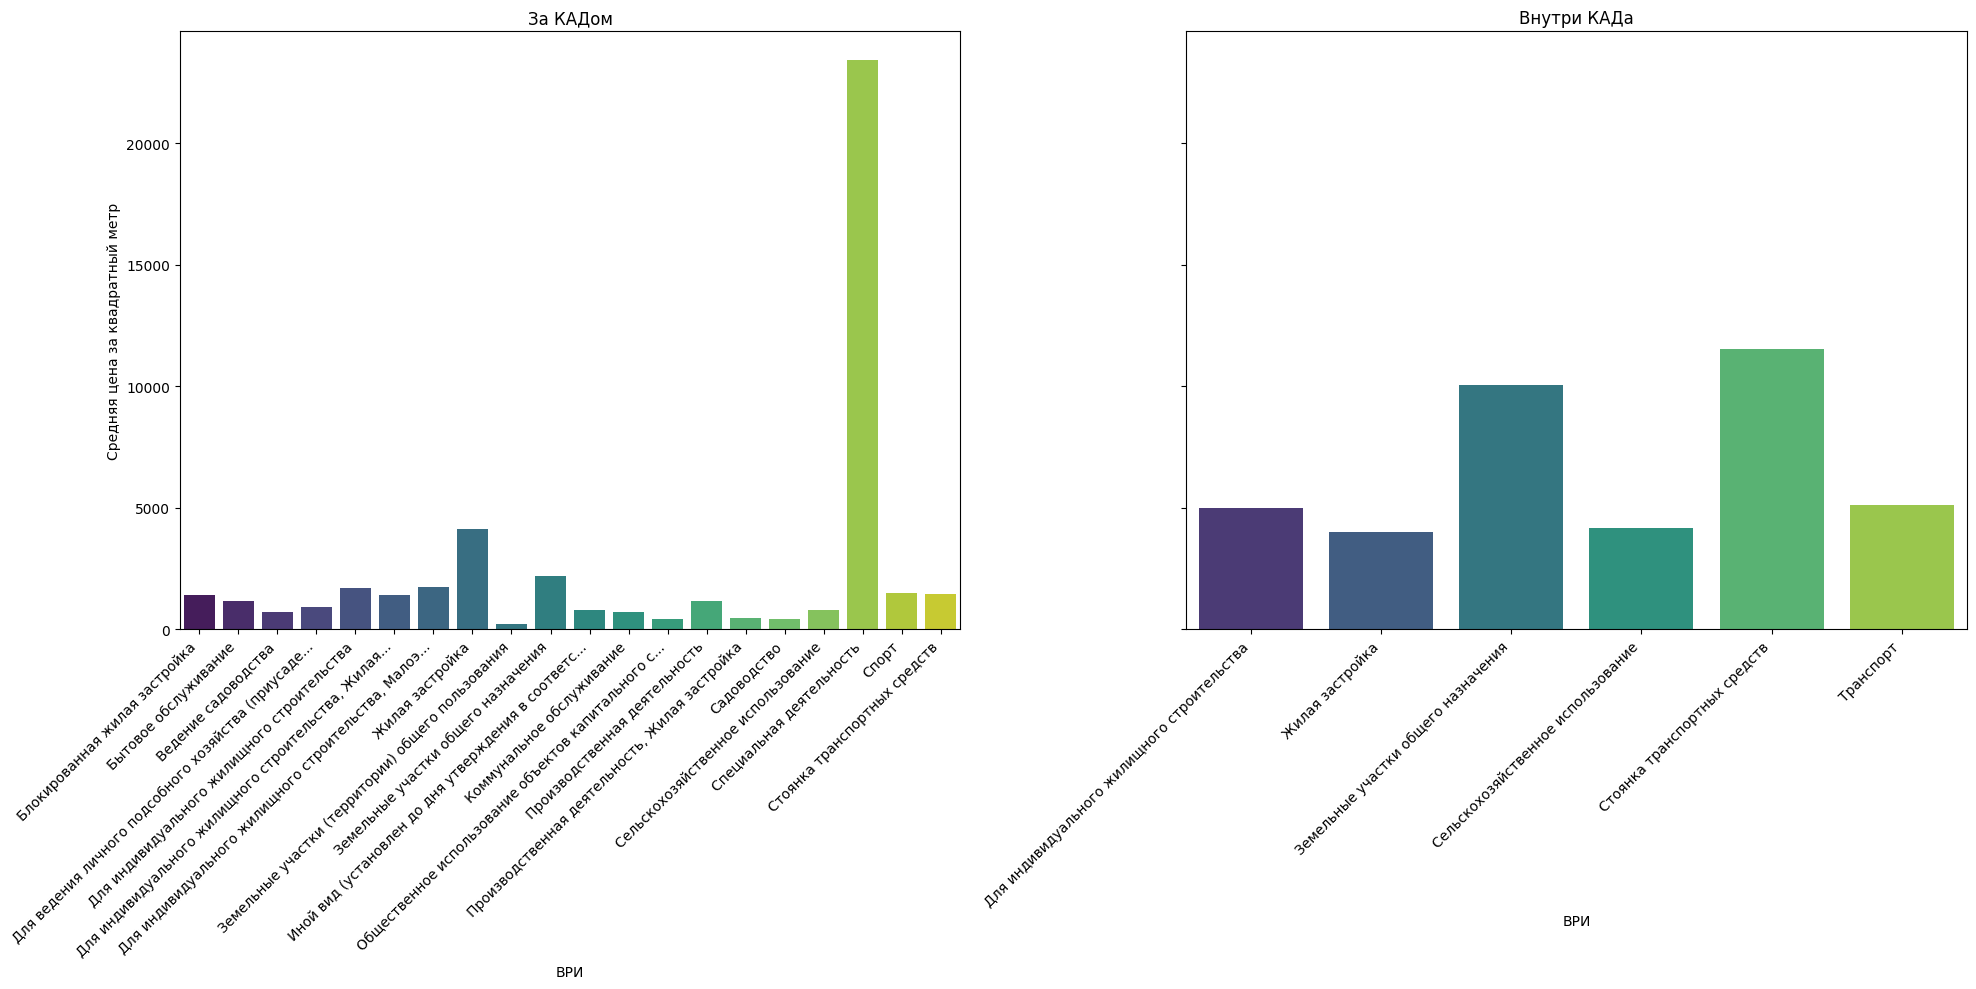

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

for in_cad in [False, True]:
  ax = axs[int(in_cad)]

  target_entries = data[data["Внутри КАДа"] == in_cad][["ВРИ", "Начальная цена за квадратный метр"]]

  mean_prices = target_entries.groupby('ВРИ').mean().reset_index()
  mean_prices.columns = ['ВРИ', 'Средняя цена']

  # Сокращаем названия, чтобы помещались
  def truncate_labels(label, max_length=50):
      if len(label) > max_length:
          return label[:max_length] + '...'
      return label

  mean_prices['ВРИ'] = mean_prices['ВРИ'].apply(lambda x: truncate_labels(x))

  sns.barplot(x='ВРИ', y='Средняя цена', data=mean_prices, palette='viridis', ax=ax)

  ax.set_ylabel('Средняя цена за квадратный метр')
  ax.set_title("Внутри КАДа" if in_cad
                            else "За КАДом")

  ax.set_xticklabels(mean_prices["ВРИ"], rotation=45, ha="right")

plt.tight_layout()
plt.show();

Для объектов за КАДом самая дорогая недвижимость имеет ВРИ "Специальная деятельность":
*размещение, хранение, захоронение, утилизация, накопление, обработка, обезвреживание отходов производства и потребления, медицинских отходов, биологических отходов, радиоактивных отходов, веществ, разрушающих озоновый слой, а также размещение объектов размещения отходов, захоронения, хранения, обезвреживания таких отходов (скотомогильников, мусоросжигательных и мусороперерабатывающих заводов, полигонов по захоронению и сортировке бытового мусора и отходов, мест сбора вещей для их вторичной переработки)*

Это можно объяснить высокими требованиями к безопасности и технологии, ограниченным количеством таких объектов, административными барьерами и экономической и экологической выгодой участка.

Внутри КАДа - ВРИ "Стоянка транспортных средств".
Это также можно объяснить близким расположением к главным транспортным узлам и трассам, доходностью от логистических компаний, экономией на затратах и высоким спросом на стоянки внутри города.

# Выводы

Отвечаю на поставленные вопросы и комментирую выдвинутые гипотезы

1) Дельты между начальной и конечной ценой(для объектов, выставляемых на аукцион) действительно выше в июне и июле. это связано с тем, что любовь к риску у инвесторов зависит от настроения, погоды, времени года(на самом деле, даже от времени [суток](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7381795/), но это не вошло в мое исследование)

2) С ростом общей площади цена на объекты внутри КАДа растет быстрее, чем цена на объекты за КАДом.

3) Самый "дорогой" ВРИ у объектов внутри КАДа - стоянка транспортных средств. У объектов за КАДом - специальная деятельность.